# This notebook will create figures


- overview TS diagrams for the two years (maybe animation, maybe just 2x2 annual difference for the months); purpose of this is grounding
- compare overall (animation) the differences (anomalies) between the two years (what we expect)
- basin tendencies vs gateways (Pemberton figure 12, overall for 1 year)
- WMT comparison (year a vs b) highlight similarities and differences and what we see in this that we don't see in other versions)
- seasonal JFM, ... etc for the differences between the seasons with gateway transports
- anomaly possibly to highlight the regions/or differences (map view) of this change)

In [1]:
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

In [2]:
import h5py
from scipy.io import loadmat
from scipy.io import savemat

In [3]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [5]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/presentation_fall_2025/figs/"
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/"
dirrun = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirState = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [8]:
# load for 2007
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries = loaded_data["salt_transport_timeseries"]
theta_timeseries = loaded_data["theta_timeseries"]
salt_timeseries = loaded_data["salt_timeseries"]
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]

# load for 2016
# loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2016.npy", allow_pickle=True).item()

# # Access the saved dictionaries
# heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
# salt_transport_timeseries = loaded_data["salt_transport_timeseries"]
# theta_timeseries = loaded_data["theta_timeseries"]
# salt_timeseries = loaded_data["salt_timeseries"]
# binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
# binned_salt_timeseries = loaded_data["binned_salt_timeseries"]

## Figure 1: Create a similar volume distribution to how we did in lookatlayers_TS for 2016 so we can compare

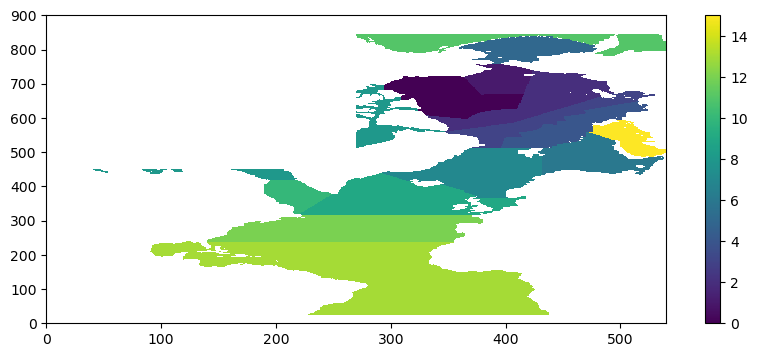

In [6]:
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [7]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
print(nT)

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
print(nS)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
print(binwidthT.shape)
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

112
112
(112,)


In [12]:
# load the 2016 volume distribution
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "vol_distrib_BarentsS.npz", allow_pickle=True)
vol_distrib_2016 = dict(loaded)
# vol_distrib_2016

# load the 2007 volume distribution
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "vol_distrib_BarentsS.npz", allow_pickle=True)
vol_distrib_2007 = dict(loaded)

In [16]:
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(2,13,1)
times["2017"] = np.arange(1,2,1)

tsstr_2016,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

times = {}
times["2007"] = np.arange(2,13,1)
times["2008"] = np.arange(1,2,1)

tsstr_2007,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)



In [19]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


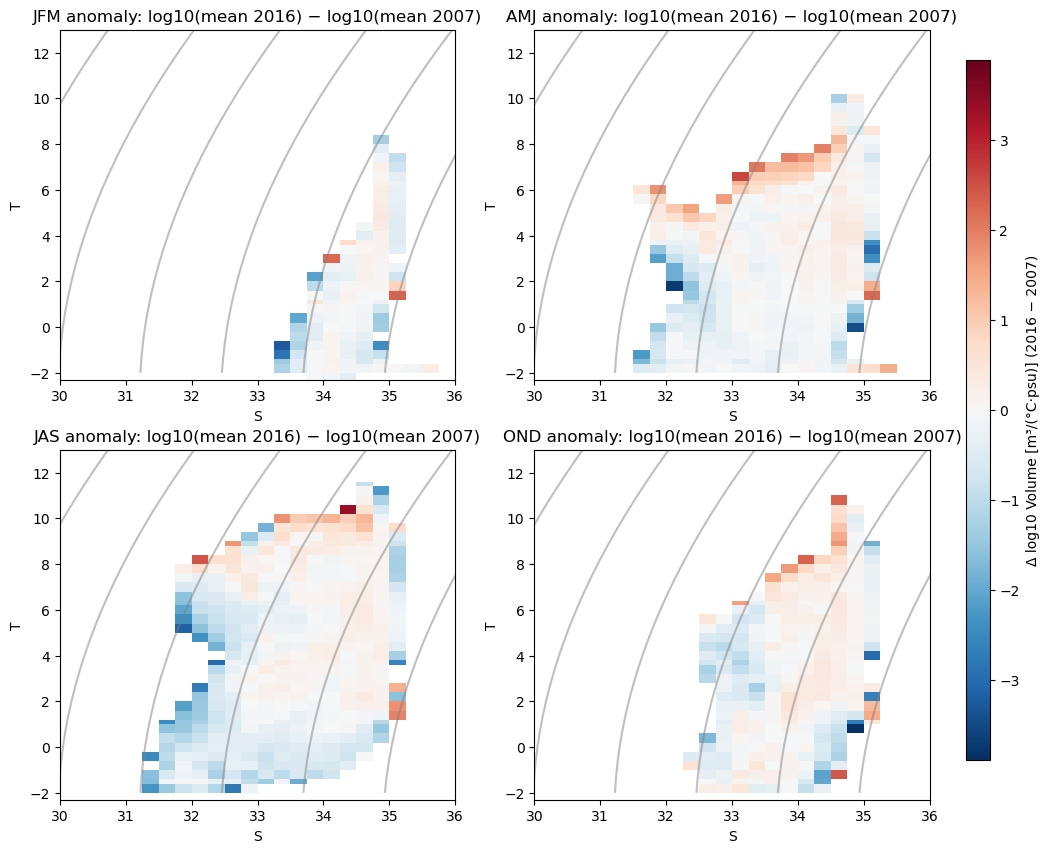

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# seasons as index groups (0-based: Jan=0 … Dec=11)
season_slices = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9, 10, 11],
}

def seasonal_mean_from_lists(vol_dict, ts_list, idxs):
    fields = [vol_dict[ts_list[i]] for i in idxs]
    return np.nanmean(np.stack(fields, axis=0), axis=0)

# anomalies
anom = {}
for label, idxs in season_slices.items():
    mean16 = seasonal_mean_from_lists(vol_distrib_2016, tsstr_2016, idxs)
    mean07 = seasonal_mean_from_lists(vol_distrib_2007, tsstr_2007, idxs)

    eps = 1e-30
    log16 = np.log10(np.maximum(mean16, eps))
    log07 = np.log10(np.maximum(mean07, eps))
    anom[label] = log16 - log07

# symmetric color limits
allvals = np.concatenate([v.ravel() for v in anom.values()])
finite = allvals[np.isfinite(allvals)]
vmax = float(np.nanmax(np.abs(finite))) if finite.size else 1.0
vmin = -vmax

# make figure + axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
order = ["JFM", "AMJ", "JAS", "OND"]

mappable = None
for ax, label in zip(axes, order):
    mappable = ax.pcolormesh(
        Sbin, Tbin, anom[label].T,
        cmap="RdBu_r", vmin=vmin, vmax=vmax
    )
    ax.set_title(f"{label} anomaly: log10(mean 2016) − log10(mean 2007)")
    ax.set_xlabel("S"); ax.set_ylabel("T")
    ax.set_xlim(xlims); ax.set_ylim(ylims)

    cs = ax.contour(si, ti, dens2, colors="grey", alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

# tighten layout to leave space for colorbar
fig.subplots_adjust(right=0.85)  # plots occupy up to 85% of width

# add a new axis for colorbar farther to the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label("Δ log10 Volume [m³/(°C·psu)] (2016 − 2007)")

plt.savefig(imgpath + "TS_seasonal_anomaly_2016_minus_2007.png", dpi=300)
plt.show()

### Figure 12 from Pemberton / total tendency vs gateway transports

In [27]:
# load the gateway transports for 2007
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", allow_pickle=True).item()

heat_transport_timeseries07 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries07 = loaded_data["salt_transport_timeseries"]
theta_timeseries07 = loaded_data["theta_timeseries"]
salt_timeseries07 = loaded_data["salt_timeseries"]
binned_theta_timeseries07 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries07 = loaded_data["binned_salt_timeseries"]

# load the gateway transports for 2016
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2016.npy", allow_pickle=True).item()

heat_transport_timeseries16 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries16 = loaded_data["salt_transport_timeseries"]
theta_timeseries16 = loaded_data["theta_timeseries"]
salt_timeseries16 = loaded_data["salt_timeseries"]
binned_theta_timeseries16 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries16 = loaded_data["binned_salt_timeseries"]

In [29]:
# tendencies for 2007
filename = "Jy_data_full.npz"

matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jy_2007 = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_2007 = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}

In [30]:
# tendencies for 2016
filename = "Jy_data_full.npz"

matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000262944_bro/"
loaded_data = np.load(matpath + filename, allow_pickle=True)
Jy_2016 = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}

# Define your filename
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000262944_bro/"
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_2016 = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}

In [31]:
# compute the gate transports

# now to try and show that this gate convergence fits with previous solution
def m_TS_from_prebinned(heat_tr, salt_tr, iT, iS, Tcent, Scent, binwidthT, binwidthS,
                        T_min=1e-3, S_min=1e-4):
    """
    Inputs:
      heat_tr : (nz, nfaces)  degC·m^3/s  (T*Q)
      salt_tr : (nz, nfaces)  psu·m^3/s   (S*Q)
      iT, iS  : (nz, nfaces)  integer bin indices in [0..nT-1],[0..nS-1]
      Tcent   : (nT,)         bin centers (degC)
      Scent   : (nS,)         bin centers (psu)
    Output:
      m_TS    : (nS, nT)      Sv/(psu·°C)
    """
    nT = len(Tcent); nS = len(Scent)
    m_TS = np.zeros((nS-1, nT-1), dtype=float)

    # Flatten
    HT  = heat_tr.reshape(-1)              # degC·m^3/s
    ST  = salt_tr.reshape(-1)              # psu·m^3/s
    iTf = iT.reshape(-1).astype(int)
    iSf = iS.reshape(-1).astype(int)

    # Valid bins
    valid = (iTf >= 0) & (iTf < nT) & (iSf >= 0) & (iSf < nS)
    if not np.any(valid):
        return m_TS

    iTv = iTf[valid]; iSv = iSf[valid]
    HTv = HT[valid];  STv = ST[valid]

    # Get bin-center T,S for those indices
    Tv = Tcent[iTv]; Sv = Scent[iSv]

    # Recover Q (m^3/s). Prefer salt (often better conditioned), fallback to heat.
    Qs = np.where(np.abs(Sv) > S_min, STv / Sv, np.nan)
    Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
    Q  = np.where(np.isfinite(Qs), Qs, Qt)
    Q  = np.where(np.isfinite(Q), Q, 0.0)   # m^3/s (+ into basin)

    # Convert to Sv and normalize by ΔS·ΔT → Sv/(psu·°C)
    dSv = binwidthS[iSv]; dTv = binwidthT[iTv]
    contrib = (Q * 1e-6) / (dSv * dTv)

    np.add.at(m_TS, (iSv, iTv), contrib)
    return m_TS


# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [35]:

def m_TS_total_from_timeseries(
    heat_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    salt_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    iT_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    iS_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    Tcent, Scent,             # bin centers
    binwidthT, binwidthS,     # bin widths
    year_idx,
    months=None,              # list of month indices to average (e.g., [0,1,2]); if None, uses all 12
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"            # "mean" or "sum" across selected months
):
    """
    Build m_TS_total (Sv/(psu·°C)) by:
      1) computing m_TS_from_prebinned per month per gate,
      2) averaging (or summing) across the selected months per gate,
      3) summing across gates.

    Parameters
    ----------
    heat_ts_by_gate, salt_ts_by_gate, iT_ts_by_gate, iS_ts_by_gate : dict[str, np.ndarray]
        Each maps gate -> array shaped [nyear, 12, nz, nfaces] (int types for iT/iS).
    Tcent, Scent : 1D arrays
        Bin centers for T and S.
    binwidthT, binwidthS : 1D arrays
        Bin widths for T and S. Assumes `m_TS_from_prebinned` expects these.
    year_idx : int
        Index into the 'year' dimension of the timeseries arrays.
    months : list[int] | None
        0-based month indices to average. If None, uses range(12).
    gates : iterable[str]
        Gates to include.
    reducer : {"mean", "sum"}
        How to combine over months (default "mean").

    Returns
    -------
    m_TS_total : 2D np.ndarray
        Seasonal-aggregated m_TS summed over the provided gates, units Sv/(psu·°C).
    """
    if months is None:
        months = list(range(12))
    # sanity-check month indices
    months = [int(m) for m in months]
    if any((m < 0 or m > 11) for m in months):
        raise ValueError(f"Month indices must be in [0,11]; got {months}")

    # Helper to combine across months
    def _combine(stack, reducer):
        if reducer == "mean":
            return np.nanmean(stack, axis=0)
        elif reducer == "sum":
            return np.nansum(stack, axis=0)
        else:
            raise ValueError(f"Unknown reducer: {reducer}")

    m_by_gate = {}

    for g in gates:
        m_list = []
        for m in months:
            HT = heat_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            ST = salt_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            iT = iT_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints
            iS = iS_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints

            # User-provided function: returns m_TS on (S,T) bins, units Sv/(psu·°C)
            m_gate_month = m_TS_from_prebinned(HT, ST, iT, iS, Tcent, Scent, binwidthT, binwidthS)
            m_list.append(m_gate_month)

        # average (or sum) across selected months for this gate
        m_by_gate[g] = _combine(np.stack(m_list, axis=0), reducer)

    # sum over gates to get the total
    m_TS_total = np.sum([m_by_gate[g] for g in gates], axis=0)
    return m_TS_total


months_all = list(range(12))
m_TS_total_2007 = m_TS_total_from_timeseries(
    heat_transport_timeseries07,
    salt_transport_timeseries07,
    binned_theta_timeseries07,
    binned_salt_timeseries07,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_all,
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"
)

m_TS_total_2016 = m_TS_total_from_timeseries(
    heat_transport_timeseries16,
    salt_transport_timeseries16,
    binned_theta_timeseries16,
    binned_salt_timeseries16,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_all,
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"
)


In [48]:
nbasin = "BarentsS"

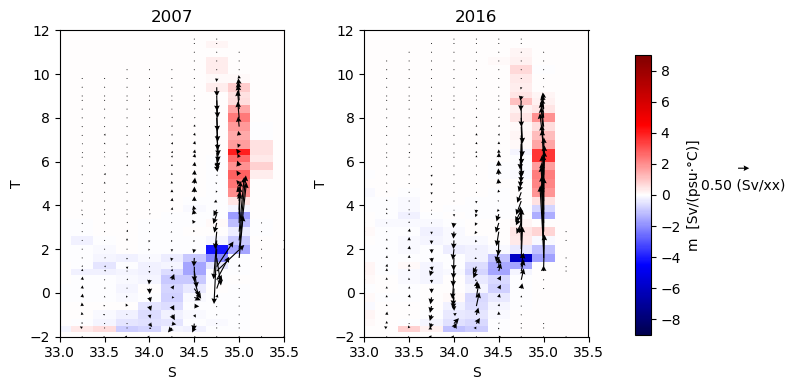

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Tunables / style controls
# --------------------------
vmin, vmax = -9, 9

# Optional anisotropic scaling for the quiver components
alpha_x = 1.0   # multiplies Jx (Sv/degC)
beta_y  = 1.0   # multiplies Jy (Sv/PSU)

# Subsample to declutter arrows (set to 2 or 3 to thin further)
skip = 1

# Quiver scale (same semantics as your example)
quiver_scale = 1e1

# Single quiver key magnitude (shown in label)
U_key = 0.5  # choose a representative magnitude

# --------------------------
# Helper: mask zeros, scale, subsample
# --------------------------
def prep_quiver(U, V, alpha_x=1.0, beta_y=1.0, skip=1):
    U = U.copy()
    V = V.copy()
    # mask zeros to declutter
    U[U == 0] = np.nan
    V[V == 0] = np.nan
    # apply anisotropic scaling
    U *= alpha_x
    V *= beta_y
    # subsample (optional)
    if skip > 1:
        U = U[::skip, ::skip]
        V = V[::skip, ::skip]
    return U, V

# If Sbin2/Tbin2 are not 2D center grids, build them from edges Sbin/Tbin:
# Scent2 = 0.5*(Sbin[:-1] + Sbin[1:])
# Tcent2 = 0.5*(Tbin[:-1] + Tbin[1:])
# Sbin2, Tbin2 = np.meshgrid(Scent2, Tcent2)

# --------------------------
# Prepare quiver inputs
# --------------------------
U07, V07 = prep_quiver(U_mean07, V_mean07, alpha_x=alpha_x, beta_y=beta_y, skip=skip)
U16, V16 = prep_quiver(U_mean16, V_mean16, alpha_x=alpha_x, beta_y=beta_y, skip=skip)

# Subsample coordinates to match quiver if needed
if skip > 1:
    Sq = Sbin2[::skip, ::skip]
    Tq = Tbin2[::skip, ::skip]
else:
    Sq = Sbin2
    Tq = Tbin2

# --------------------------
# Plotting
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes

# Left: 2007
im1 = ax1.pcolormesh(Sbin2, Tbin2, m_TS_total_2007, cmap="seismic", vmin=vmin, vmax=vmax)
q1  = ax1.quiver(Sq, Tq, U07, V07, width=0.005, zorder=3, headwidth=5, scale=quiver_scale)
ax1.set_xlim(33, 35.5)
ax1.set_ylim(-2, 12)
ax1.set_title("2007")
ax1.set_xlabel("S")
ax1.set_ylabel("T")

# Right: 2016 (use the same quiver scale for consistency)
im2 = ax2.pcolormesh(Sbin2, Tbin2, m_TS_total_2016, cmap="seismic", vmin=vmin, vmax=vmax)
q2  = ax2.quiver(Sq, Tq, U16, V16, width=0.005, zorder=3, headwidth=5, scale=quiver_scale)
ax2.set_xlim(33, 35.5)
ax2.set_ylim(-2, 12)
ax2.set_title("2016")
ax2.set_xlabel("S")
ax2.set_ylabel("T")

# --------------------------
# Shared colorbar (far right)
# --------------------------
fig.subplots_adjust(right=0.78)                 # leave space on the right for cbar + key
cax = fig.add_axes([0.80, 0.15, 0.02, 0.70])    # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label("m  [Sv/(psu·°C)]")

# --------------------------
# Single quiver key far outside both plots
# --------------------------
# Put the key in its own small (invisible) axes to the right of the colorbar.
qk_ax = fig.add_axes([0.84, 0.22, 0.14, 0.56])  # ample room, well outside the panels
qk_ax.axis('off')

# Use q1 as the reference for scaling; label includes both component units.
qk_ax.quiverkey(
    q1, X=3.05, Y=0.55, U=U_key,
    label=f"{U_key:.2f} (Sv/xx)",
    labelpos='S', coordinates='axes'
)

# Final layout & save
plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig(imgpath + "mTS_2007_2016_side_by_side_single_quiverkey.png", dpi=300)
plt.show()


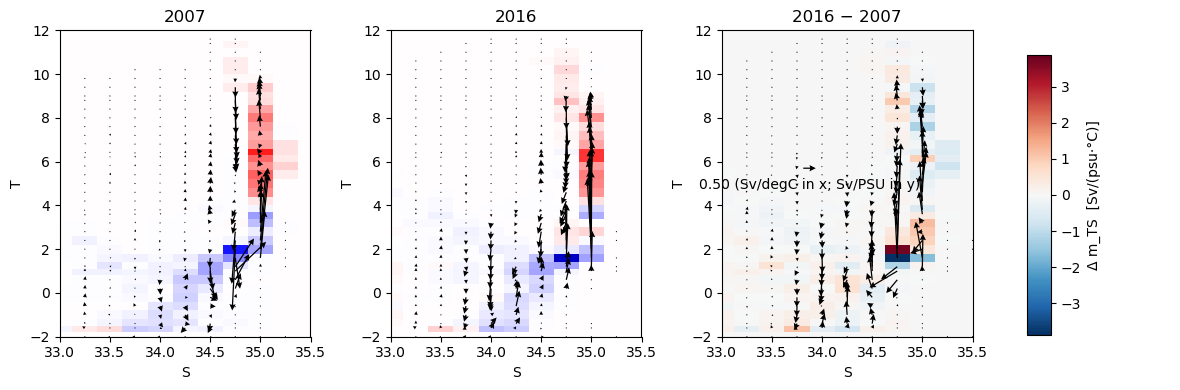

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def prep_quiver(U, V, skip=1, mask_thresh=None):
    U = U.copy(); V = V.copy()
    if mask_thresh is None:
        # mask exact zeros
        m = (U == 0) & (V == 0)
    else:
        m = (np.hypot(U, V) < mask_thresh)
    U[m] = np.nan; V[m] = np.nan
    if skip > 1:
        U = U[::skip, ::skip]; V = V[::skip, ::skip]
    return U, V

# If Sbin2/Tbin2 are centers as 2D meshes, keep them; else build centers from edges.
# Scent2 = 0.5*(Sbin[:-1] + Sbin[1:]); Tcent2 = 0.5*(Tbin[:-1] + Tbin[1:])
# Sbin2, Tbin2 = np.meshgrid(Scent2, Tcent2)

# ---------- fields ----------
# Scalars
m07 = m_TS_total_2007
m16 = m_TS_total_2016
mdiff = m16 - m07  # or use log-ratio: np.log10(np.maximum(m16,eps)) - np.log10(np.maximum(m07,eps))

# Vectors (annual means you already computed)
U07, V07 = U_mean07, V_mean07
U16, V16 = U_mean16, V_mean16
Ud,  Vd  = (U16 - U07), (V16 - V07)

# Declutter vectors
skip = 1          # set to 2 or 3 to thin arrows further
mask_thresh = None  # or a small number like 0.02 to hide tiny vectors
U07p, V07p = prep_quiver(U07, V07, skip=skip, mask_thresh=mask_thresh)
U16p, V16p = prep_quiver(U16, V16, skip=skip, mask_thresh=mask_thresh)
Udp,  Vdp  = prep_quiver(Ud,  Vd,  skip=skip, mask_thresh=mask_thresh)

# Match coords for quiver if subsampled
Sq = Sbin2[::skip, ::skip] if skip > 1 else Sbin2
Tq = Tbin2[::skip, ::skip] if skip > 1 else Tbin2

# Color limits
vmin, vmax = -9, 9
mm = np.nanmax(np.abs(mdiff))
vmin_d, vmax_d = -mm, mm

# ---------- plot ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1, ax2, ax3 = axes

# 2007
im1 = ax1.pcolormesh(Sbin2, Tbin2, m07, cmap="seismic", vmin=vmin, vmax=vmax)
q1  = ax1.quiver(Sq, Tq, U07p, V07p, width=0.005, headwidth=5, scale=1e1, zorder=3)
ax1.set_title("2007"); ax1.set_xlim(33, 35.5); ax1.set_ylim(-2, 12); ax1.set_xlabel("S"); ax1.set_ylabel("T")

# 2016
im2 = ax2.pcolormesh(Sbin2, Tbin2, m16, cmap="seismic", vmin=vmin, vmax=vmax)
q2  = ax2.quiver(Sq, Tq, U16p, V16p, width=0.005, headwidth=5, scale=1e1, zorder=3)
ax2.set_title("2016"); ax2.set_xlim(33, 35.5); ax2.set_ylim(-2, 12); ax2.set_xlabel("S"); ax2.set_ylabel("T")

# Difference panel (highlights change)
im3 = ax3.pcolormesh(Sbin2, Tbin2, mdiff, cmap="RdBu_r", vmin=vmin_d, vmax=vmax_d)
q3  = ax3.quiver(Sq, Tq, Udp, Vdp, width=0.005, headwidth=5, scale=1e1, zorder=3)
ax3.set_title("2016 − 2007"); ax3.set_xlim(33, 35.5); ax3.set_ylim(-2, 12); ax3.set_xlabel("S"); ax3.set_ylabel("T")

# Colorbar for the anomaly only (draws the eye to differences)
fig.subplots_adjust(right=0.84)
cax = fig.add_axes([0.86, 0.15, 0.02, 0.70])
cbar = fig.colorbar(im3, cax=cax)
cbar.set_label("Δ m_TS  [Sv/(psu·°C)]")

# One shared quiver key far outside
qk_ax = fig.add_axes([0.90, 0.25, 0.08, 0.50])  # to the right of the cbar
qk_ax.axis('off')
U_key = 0.5
qk_ax.quiverkey(q3, X=0.35, Y=0.55, U=U_key,
                label=f"{U_key:.2f} (Sv/degC in x; Sv/PSU in y)",
                labelpos='S', coordinates='axes')

plt.tight_layout(rect=[0, 0, 0.84, 1])
plt.savefig(imgpath + "mTS_2007_2016_plus_difference.png", dpi=300)
plt.show()


## Figure 3? 4? Look at the gateway transport for an example year to explain what transformations we expect to see

In [68]:
def compute_gradient_manual(data_s, data_t, spacing_s, spacing_t):
    # Gradient for salinity along axis 0
    gradient_s = np.zeros_like(data_s)
    gradient_s[1:-1] = (data_s[2:] - data_s[:-2]) / (spacing_s[2:] + spacing_s[:-2])
    gradient_s[0] = (data_s[1] - data_s[0]) / spacing_s[1]  # forward difference at start
    gradient_s[-1] = (data_s[-1] - data_s[-2]) / spacing_s[-1]  # backward difference at end

    # Gradient for temperature along axis 1
    gradient_t = np.zeros_like(data_t)
    gradient_t[:, 1:-1] = (data_t[:, 2:] - data_t[:, :-2]) / (spacing_t[:, 2:] + spacing_t[:, :-2])
    gradient_t[:, 0] = (data_t[:, 1] - data_t[:, 0]) / spacing_t[:, 1]  # forward difference at start
    gradient_t[:, -1] = (data_t[:, -1] - data_t[:, -2]) / spacing_t[:, -1]  # backward difference at end

    return gradient_s, gradient_t

In [94]:
# choose the time steps of interest
months_all = list(range(12))
months_jas = np.array([6,7,8])

# get the m term
m_TS_sample_2007 = m_TS_total_from_timeseries(
    heat_transport_timeseries07,
    salt_transport_timeseries07,
    binned_theta_timeseries07,
    binned_salt_timeseries07,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_jas,
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"
)

m_TS_sample_2016 = m_TS_total_from_timeseries(
    heat_transport_timeseries07,
    salt_transport_timeseries07,
    binned_theta_timeseries07,
    binned_salt_timeseries07,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_jas,
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"
)

# get the J terms (avg of the year)


# then can move on to plotting

In [104]:
# choose the time
mytimes = np.arange(0,12,1)
mytimes = np.array([6,7,8])

a = binmidTp[:,0].reshape(111)
a.shape
b = binmidSp[:,0].reshape(111)
b.shape

binwidthTtile = np.tile(a[np.newaxis,:],(nS-1,1))
binwidthStile = np.tile(b[:,np.newaxis],(1,nT-1))

# shape = Jx_2007[nbasin][mytime]['LSto_TS'].T
div_J_all = np.zeros((len(mytimes),111,111))
div_Ja_all = np.zeros((len(mytimes),111,111))
div_Jd_all = np.zeros((len(mytimes),111,111))
div_Jsurf_all = np.zeros((len(mytimes),111,111))

# compute the gradients based on the layers
# overall tendency
ii = 0
for i in mytimes:
    mytime = tsstr_2007[i]
    
    J_S_div, J_T_div = compute_gradient_manual(Jx_2007[nbasin][mytime]['LSto_TS'].T, Jy_2007[nbasin][mytime]['LTto_TS'].T, binwidthStile, binwidthTtile)
    div_J = J_S_div + J_T_div
    
    # advective tend (should be able to be ignored by the gates)
    J_S_div, J_T_div = compute_gradient_manual(Jx_2007[nbasin][mytime]['LSza_TS'].T + Jx_2007[nbasin][mytime]['LSha_TS'].T, Jy_2007[nbasin][mytime]['LTza_TS'].T + Jy_2007[nbasin][mytime]['LTha_TS'].T, binwidthStile, binwidthTtile)
    div_Ja = J_S_div + J_T_div
    
    # diffusive tend
    J_S_div, J_T_div = compute_gradient_manual(Jx_2007[nbasin][mytime]['LaSz_TS'].T + Jx_2007[nbasin][mytime]['LaSh_TS'].T, Jy_2007[nbasin][mytime]['LaTz_TS'].T + Jy_2007[nbasin][mytime]['LaTh_TS'].T, binwidthStile, binwidthTtile)
    div_Jd = J_S_div + J_T_div
    
    # surface tend
    J_S_div, J_T_div = compute_gradient_manual(Jx_2007[nbasin][mytime]['LaSs_TS'].T, Jy_2007[nbasin][mytime]['LaTs_TS'].T, binwidthStile, binwidthTtile)
    div_Jsurf = J_S_div + J_T_div

    # set in the larger array
    div_J_all[ii] = div_J
    div_Ja_all[ii] = div_Ja
    div_Jd_all[ii] = div_Jd
    div_Jsurf_all[ii] = div_Jsurf

    ii += 1

# average these in time
div_J = np.nanmean(div_J_all,axis=0)
div_Ja = np.nanmean(div_Ja_all,axis=0)
div_Jd = np.nanmean(div_Jd_all,axis=0)
div_Jsurf = np.nanmean(div_Jsurf_all,axis=0)

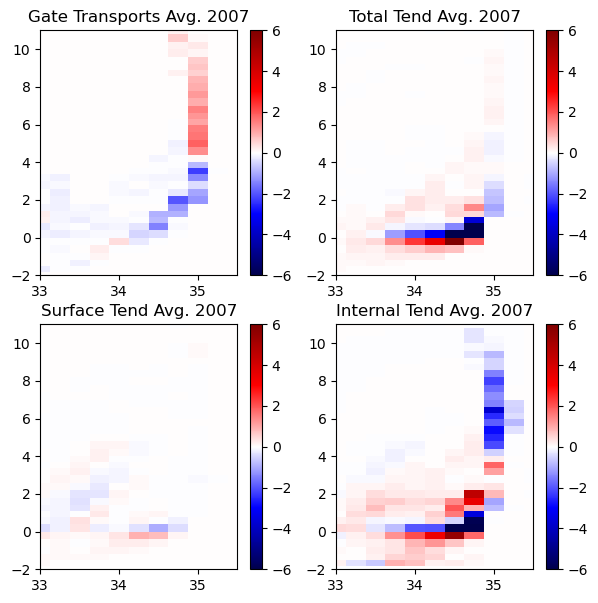

In [105]:
# plot figure 16 for this month as in Pemberton
fig = plt.figure(figsize = (7,7))

vlev = 6

# gateway transports
ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin2,Tbin2,(m_TS_sample_2007),cmap="seismic",vmin=-vlev,vmax=vlev)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,11)
ax.set_title("Gate Transports Avg. 2007")

# total divergence (total tend)
ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,11)
plt.colorbar(cb)
ax.set_title("Total Tend Avg. 2007")


# divergence due to surface processes
ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jsurf),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,11)
plt.colorbar(cb)
ax.set_title("Surface Tend Avg. 2007")

# divergence due to internal processes
ax = plt.subplot(224)
a = m_TS_total_2007
b = div_Ja - m_TS_total_2007
div_Jint = -(- div_Jd - div_Ja - m_TS_total_2007)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jint),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,11)
plt.colorbar(cb)
ax.set_title("Internal Tend Avg. 2007")

plt.savefig(imgpath + "overall_2007_transform_JAS.png", dpi=300)

### Do the same for 2016

In [106]:
# choose the time
mytimes = np.arange(0,12,1)
mytimes = np.array([6,7,8])

a = binmidTp[:,0].reshape(111)
a.shape
b = binmidSp[:,0].reshape(111)
b.shape

binwidthTtile = np.tile(a[np.newaxis,:],(nS-1,1))
binwidthStile = np.tile(b[:,np.newaxis],(1,nT-1))

# shape = Jx_2007[nbasin][mytime]['LSto_TS'].T
div_J_all = np.zeros((len(mytimes),111,111))
div_Ja_all = np.zeros((len(mytimes),111,111))
div_Jd_all = np.zeros((len(mytimes),111,111))
div_Jsurf_all = np.zeros((len(mytimes),111,111))

# compute the gradients based on the layers
# overall tendency
ii = 0
for i in mytimes:
    mytime = tsstr_2016[i]
    
    J_S_div, J_T_div = compute_gradient_manual(Jx_2016[nbasin][mytime]['LSto_TS'].T, Jy_2016[nbasin][mytime]['LTto_TS'].T, binwidthStile, binwidthTtile)
    div_J = J_S_div + J_T_div
    
    # advective tend (should be able to be ignored by the gates)
    J_S_div, J_T_div = compute_gradient_manual(Jx_2016[nbasin][mytime]['LSza_TS'].T + Jx_2016[nbasin][mytime]['LSha_TS'].T, Jy_2016[nbasin][mytime]['LTza_TS'].T + Jy_2016[nbasin][mytime]['LTha_TS'].T, binwidthStile, binwidthTtile)
    div_Ja = J_S_div + J_T_div
    
    # diffusive tend
    J_S_div, J_T_div = compute_gradient_manual(Jx_2016[nbasin][mytime]['LaSz_TS'].T + Jx_2016[nbasin][mytime]['LaSh_TS'].T, Jy_2016[nbasin][mytime]['LaTz_TS'].T + Jy_2016[nbasin][mytime]['LaTh_TS'].T, binwidthStile, binwidthTtile)
    div_Jd = J_S_div + J_T_div
    
    # surface tend
    J_S_div, J_T_div = compute_gradient_manual(Jx_2016[nbasin][mytime]['LaSs_TS'].T, Jy_2016[nbasin][mytime]['LaTs_TS'].T, binwidthStile, binwidthTtile)
    div_Jsurf = J_S_div + J_T_div

    # set in the larger array
    div_J_all[ii] = div_J
    div_Ja_all[ii] = div_Ja
    div_Jd_all[ii] = div_Jd
    div_Jsurf_all[ii] = div_Jsurf

    ii += 1

# average these in time
div_J = np.nanmean(div_J_all,axis=0)
div_Ja = np.nanmean(div_Ja_all,axis=0)
div_Jd = np.nanmean(div_Jd_all,axis=0)
div_Jsurf = np.nanmean(div_Jsurf_all,axis=0)

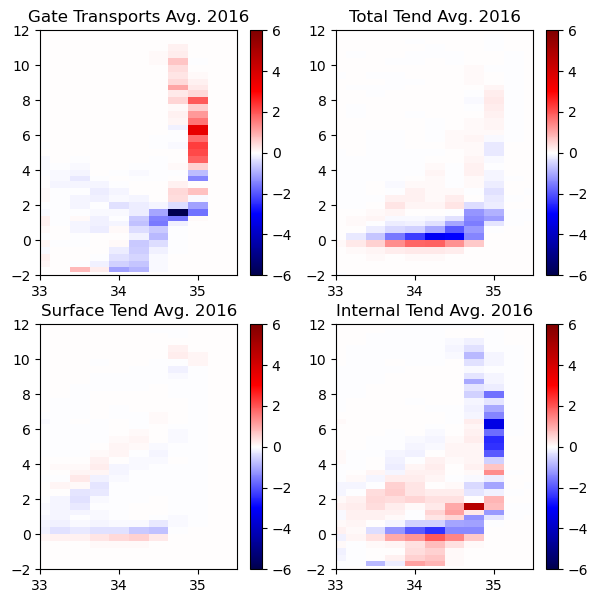

In [110]:
# plot figure 16 for this month as in Pemberton
fig = plt.figure(figsize = (7,7))

vlev = 6

# gateway transports
ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin2,Tbin2,(m_TS_total_2016),cmap="seismic",vmin=-vlev,vmax=vlev)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,12)
ax.set_title("Gate Transports Avg. 2016")

# total divergence (total tend)
ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,12)
plt.colorbar(cb)
ax.set_title("Total Tend Avg. 2016")


# divergence due to surface processes
ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jsurf),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,12)
plt.colorbar(cb)
ax.set_title("Surface Tend Avg. 2016")

# divergence due to internal processes
ax = plt.subplot(224)
a = m_TS_total_2016
b = div_Ja - m_TS_total_2016
div_Jint = -(- div_Jd - div_Ja - m_TS_total_2016)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jint),cmap="seismic",vmin=-vlev,vmax=vlev)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,12)
plt.colorbar(cb)
ax.set_title("Internal Tend Avg. 2016")

plt.savefig(imgpath + "overall_2016_transform_JAS.png", dpi=300)

### differences in JAS in freshwater creation (bigger for 2007) and warming (2016)